In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.conv_learner import *
import json
from matplotlib import patches, patheffects

In [3]:
PATH = Path('data/pascal')
# list(PATH.iterdir())
!ls {PATH}

PASCAL_VOC.zip              pascal_train2007.json
VOCdevkit                   pascal_train2012.json
VOCtrainval_06-Nov-2007.tar pascal_val2007.json
models                      pascal_val2012.json
pascal_test2007.json        tmp


In [4]:
JPEGS = 'VOCdevkit/VOC2007/JPEGImages'
IM_PATH = PATH/JPEGS

In [5]:
trn_json = json.load( (PATH/'pascal_train2007.json').open() )  # call open on the PosixPath object
trn_json.keys()

dict_keys(['images', 'type', 'annotations', 'categories'])

In [6]:
cats = {row['id']: row['name'] for row in trn_json['categories']}
trn_imgs = {row['id']: row['file_name'] for row in trn_json['images']}
trn_ids = list(trn_imgs.keys())

## dictionary => key: image_id, value: ([annotations],category_id)

In [54]:
def hw_bb(a): return np.array([a[1], a[0], a[3]+a[1], a[2]+a[0]])

trn = collections.defaultdict(lambda: [])
for row in trn_json['annotations']:
    if not row['ignore']: 
        bb = row['bbox']
        bb = hw_bb(bb)
        # PASCALVOC defaults to (col,row) of top left, height, width
        # we use (row,col) of top left, row,col of bottom right
        trn[row['image_id']].append((bb,row['category_id']))
        # appending because we're using [] as our default dict -> allows us to add multiple bboxes per image

In [7]:
def bb_hw(a): return np.array([a[1], a[0], a[3]-a[1], a[2]-a[0]])

## image display functions

In [8]:
def show_img(im, figsize=None, ax=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im)
    ax.axis('off')
    return ax

In [9]:
def draw_outline(o, lw):
    o.set_path_effects([patheffects.Stroke(linewidth=lw, foreground='black'), patheffects.Normal()])
    # draws the path twice, once w/ thick black line, again with color below

In [116]:
def draw_rectangle(ax, b, color='white'):
    o = ax.add_patch(patches.Rectangle(b[:2], *b[2:], fill=False, edgecolor=color, lw=2))
    draw_outline(o, 4)

In [11]:
def draw_text(ax, xy, txt, sz=14):
    o = ax.text(*xy, txt, verticalalignment='top', color='white', fontsize=sz, weight='bold')
    draw_outline(o, 2)

In [12]:
def draw_img(im, anno):
    ax = show_img(im, figsize=(10,6))
    for b,c in anno:
        b = bb_hw(b)
        draw_rectangle(ax, b)
        draw_text(ax, b[:2], cats[c])

In [55]:
def draw_idx(idx):
    im = open_image(IM_PATH/trn_imgs[idx])
    draw_img(im, trn[idx])
    print(im.shape)

(281, 500, 3)


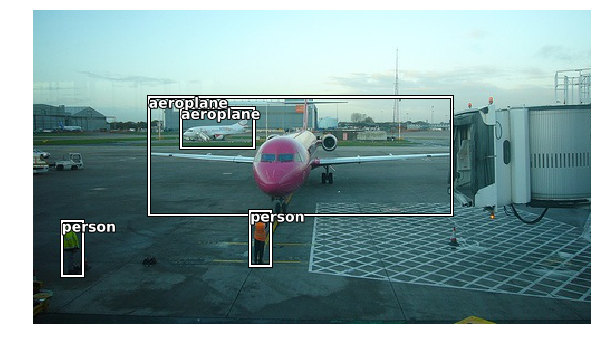

In [56]:
draw_idx(32)

## largest item classifier

In [83]:
def get_lrg(o):
    # some are empty lists due to collections.defaultdict
    if o:
        # area = (bb[2]-bb[0])*(bb[3]-bb[1])
        return sorted(o, key=lambda x: np.product(x[0][-2:]-x[0][:2]), reverse=True)[0]

In [84]:
lrg_trn = {k: get_lrg(v) for k,v in trn.items()}

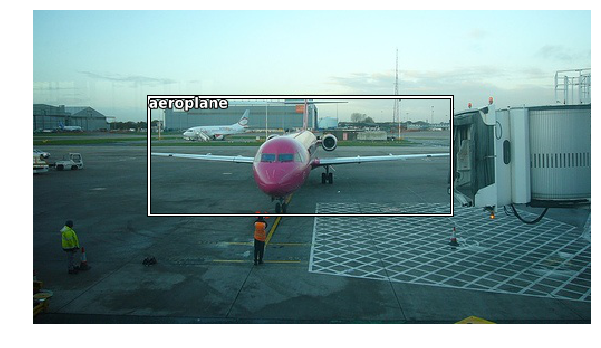

In [85]:
# check that it worked...
i = 32
im = open_image(IM_PATH/trn_imgs[i])
draw_img(im, [lrg_trn[i]])

In [86]:
(PATH/'tmp').mkdir(exist_ok=True)
CSV = PATH/'tmp'/'largest_obj.csv'

In [87]:
df = pd.DataFrame({'filename': [trn_imgs[i] for i in trn_ids],
                   'class': [cats[lrg_trn[i][1]] for i in trn_ids]},
                   columns=['filename', 'class'])
df.to_csv(CSV, index=False)

In [89]:
f = resnet34
sz = 224
bs = 64

In [90]:
tfms = tfms_from_model(f, sz, aug_tfms=transforms_side_on, crop_type=CropType.NO) # no crop, only squish
md = ImageClassifierData.from_csv(PATH, JPEGS, CSV, bs=bs, tfms=tfms)  
learn = ConvLearner.pretrained(f, md, ps=0.3, precompute=True)

A Jupyter Widget

epoch      trn_loss   val_loss   accuracy                 
    0      4.328999   708.988061 0.204     



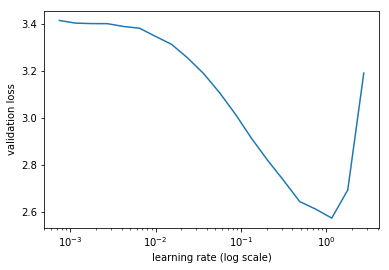

In [58]:
learn.lr_find()
learn.sched.plot(n_skip_end=1)

In [91]:
lr = 1e-1

In [92]:
learn.fit(lr, 3, cycle_len=1, wds=1e-4)

A Jupyter Widget

epoch      trn_loss   val_loss   accuracy                 
    0      1.345266   0.64059    0.792     
    1      0.937877   0.669206   0.812                     
    2      0.72258    0.675073   0.806                     


[0.67507310342788696, 0.8059999976158142]

### Precompute => sneaky!!!

In [40]:
learn.precompute = True  # only final layers are accessible to learner

# learn.model
# Sequential(
#   (0): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
#   (1): Dropout(p=0.3)
#   (2): Linear(in_features=1024, out_features=512, bias=True)
#   (3): ReLU()
#   (4): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
#   (5): Dropout(p=0.3)
#   (6): Linear(in_features=512, out_features=20, bias=True)
#   (7): LogSoftmax()
# )

# ERRORS!! predict_batch() => BatchNorm1d fails given a 4d tensor input (image)

In [93]:
learn.precompute = False  # all layers accessible to learner
learn.model

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, ker

In [ ]:
learn.fit(lr, 3, cycle_len=1, wds=1e-4)

### Check results

In [94]:
x,y = next(iter(md.val_dl))

In [95]:
res = predict_batch(learn.model, x)   #=> yields LogSoftmax
probs = np.exp(to_np(res))
preds = np.argmax(probs, axis=1)
preds

array([14, 11,  2, 14, 14,  6, 13,  8,  2,  9, 15,  6, 17,  7, 12,  0, 14, 14,  7, 19,  1,  8, 19, 13, 14, 14,
       14,  5,  9, 18, 13,  0,  2,  6, 18, 11, 12,  6,  0, 10,  6, 13, 12, 14,  3, 14, 14,  7, 12, 13,  9, 14,
       13,  2, 14, 11,  6,  0,  2,  2,  2,  7, 14,  9])

In [96]:
x = to_np(x)
x = md.val_ds.denorm(x)

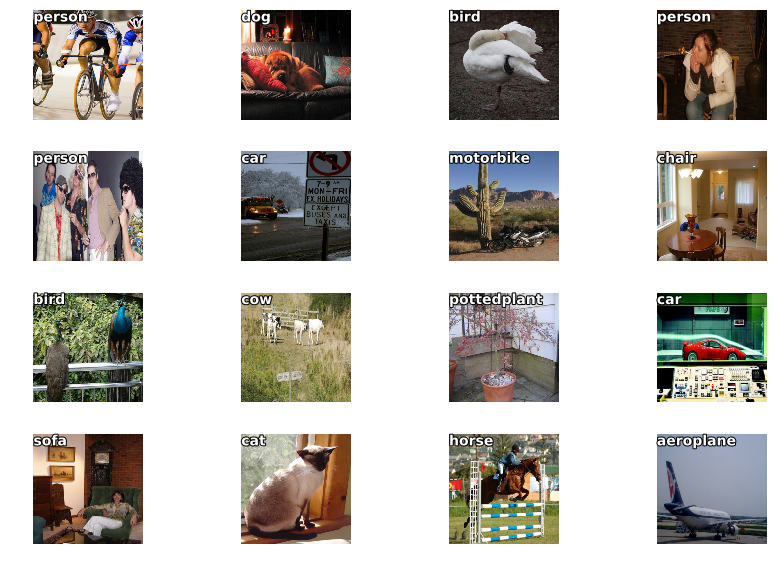

In [98]:
fig, axes = plt.subplots(4,4, figsize=(12,8))
for i,ax in enumerate(axes.flat):
    ax = show_img(x[i], ax=ax)
    draw_text(ax, (0,0), md.classes[preds[i]])
plt.tight_layout()

## bounding box of largest item
done this before: multiple object (ala planet comp) regression (ala rossman)  
- need NN to output 4 numbers (box coordinates)
- need a loss function to determine how close our coordinates are to the real thing (MSError should be fine)

In [100]:
BB_CSV = PATH/'tmp'/'largest_bb.csv'

In [102]:
df = pd.DataFrame({'filename': [trn_imgs[i] for i in trn_ids],
                   'bbox': [' '.join([str(o) for o in lrg_trn[i][0]]) for i in trn_ids]},
                   columns=['filename', 'bbox'])
df.to_csv(BB_CSV, index=False)

In [103]:
custom_reg4 = nn.Sequential(Flatten(), nn.Linear(25088, 1000), nn.Linear(1000, 4))

In [107]:
augs = [RandomRotate(30, tfm_y=TfmType.COORD),
        RandomLighting(0.1, 0.1, tfm_y=TfmType.COORD),
        RandomFlip(tfm_y=TfmType.COORD)]
tfms = tfms_from_model(f, sz, aug_tfms=augs, crop_type=CropType.NO, tfm_y=TfmType.COORD)
data = ImageClassifierData.from_csv(PATH, JPEGS, BB_CSV, bs=16, tfms=tfms, continuous=True)
learn = ConvLearner.pretrained(f, data, ps=0.3, custom_head=custom_reg4)

In [ ]:
learn.lr_find()
learn.sched.plot(n_skip_end=3)

In [108]:
lr=1e-3

In [ ]:
learn.opt_fn = optim.Adam

In [109]:
learn.fit(lr, 2, cycle_len=1, wds=1e-4)

A Jupyter Widget

  1%|          | 1/126 [00:04<09:26,  4.53s/it, loss=124]


Exception in thread Thread-16:
Traceback (most recent call last):
  File "/Users/adamschiller/anaconda3/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/Users/adamschiller/anaconda3/lib/python3.6/site-packages/tqdm/_tqdm.py", line 148, in run
    for instance in self.tqdm_cls._instances:
  File "/Users/adamschiller/anaconda3/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



epoch      trn_loss   val_loss                              
    0      33.117331  29.636633 
    1      28.822428  27.553595                             



[27.553595001220703]

In [111]:
learn.unfreeze()
lrs = np.array([lr/100, lr/10, lr])

In [112]:
learn.fit(lrs, 2, cycle_len=1, cycle_mult=2)

A Jupyter Widget

epoch      trn_loss   val_loss                              
    0      25.33382   25.325178 
    1      25.037742  29.878762                             
    2      21.593424  22.898007                             



[22.898007110595703]

In [113]:
learn.save('largest_box')

### Check results

In [114]:
x,y = next(iter(data.val_dl))

In [115]:
res = predict_batch(learn.model, x)
res

tensor([[  10.1018,   40.3746,  225.3090,  215.1257],
        [  82.9177,   11.6984,  209.1020,  200.7214],
        [  37.8300,   31.5637,  209.4451,  210.1205],
        [  38.0745,   28.5758,  224.0640,  187.4876],
        [  23.7087,   40.6517,  209.2243,  169.8136],
        [  78.0760,   46.9651,  172.1767,  163.6265],
        [  80.4910,   28.5193,  237.8205,  195.3613],
        [ 140.0305,   55.2751,  211.7907,  145.2105],
        [  49.2785,   62.5563,  215.6848,  222.6737],
        [  38.8792,   69.7814,  151.6999,  147.7355],
        [  88.8693,   52.9783,  191.6857,  142.0045],
        [  91.1465,   33.2712,  187.7813,  193.5997],
        [  87.1886,   58.1426,  205.4595,  182.9109],
        [   7.4666,   36.6471,  201.1171,  207.2323],
        [  24.6191,   64.3792,  226.2900,  222.5632],
        [  62.6929,   -2.3093,  203.3781,  164.4806]])

In [121]:
x = to_np(x)
x = md.val_ds.denorm(x)
res = to_np(res)
y = to_np(y)

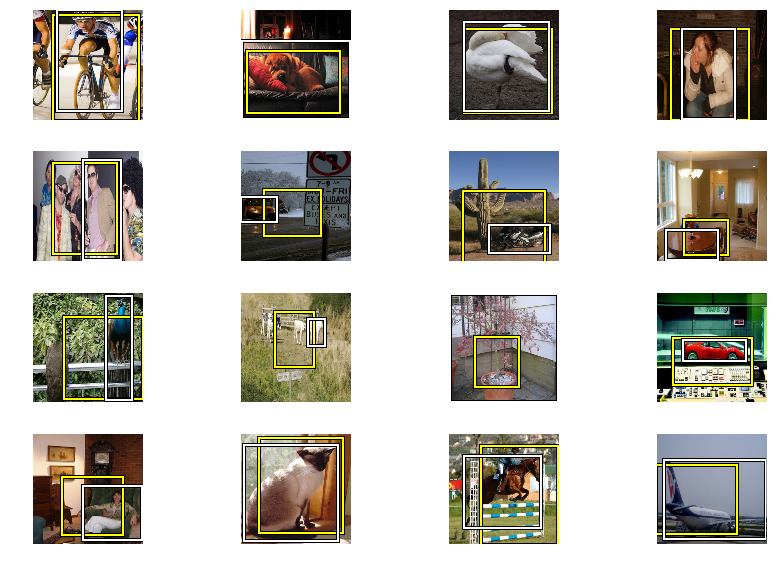

In [123]:
fig, axes = plt.subplots(4,4, figsize=(12,8))
for i,ax in enumerate(axes.flat):
    ax = show_img(x[i], ax=ax)
    draw_rectangle(ax, bb_hw(res[i]), color='yellow')
    draw_rectangle(ax, bb_hw(y[i]))
plt.tight_layout()